In [3]:

import keras
import numpy
import pandas
import os
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix

In [4]:
training_samples = []
training_labels = []
testing_samples = []

In [5]:
training_data_directory = 'train/'
testing_data_directory = 'test/'

num_classes = 7
img_rows, img_columns = 48, 48
batch_size = 16
color_channels = 1

In [6]:
# Data Augmentation
training_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

training_generator = training_gen.flow_from_directory(
    training_data_directory,
    color_mode='grayscale',
    target_size=(img_rows, img_columns),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

validation_generator = training_gen.flow_from_directory(
    training_data_directory,
    color_mode='grayscale',
    target_size=(img_rows, img_columns),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

testing_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

testing_generator = testing_gen.flow_from_directory(
    testing_data_directory,
    color_mode='grayscale',
    target_size=(img_rows, img_columns),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
directories = {}
def datasetImages(datasetPath, datasetTye):
    for dir in os.listdir(datasetPath):
        directory = datasetPath + dir
        directories[dir] = len(os.listdir(directory))
    return pandas.DataFrame(directories, index=[datasetTye])

totalTrainingImages = datasetImages(training_data_directory, 'Training Dataset')
totalTestingImages = datasetImages(testing_data_directory, 'Testing Dataset')



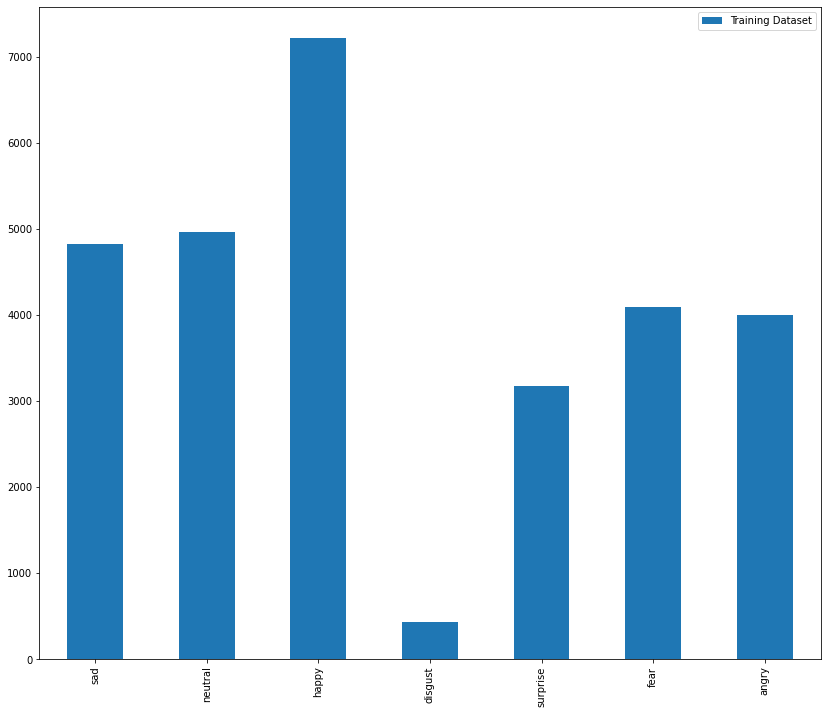

In [8]:
totalTrainingImages.transpose().plot(kind='bar', figsize=(14,12))


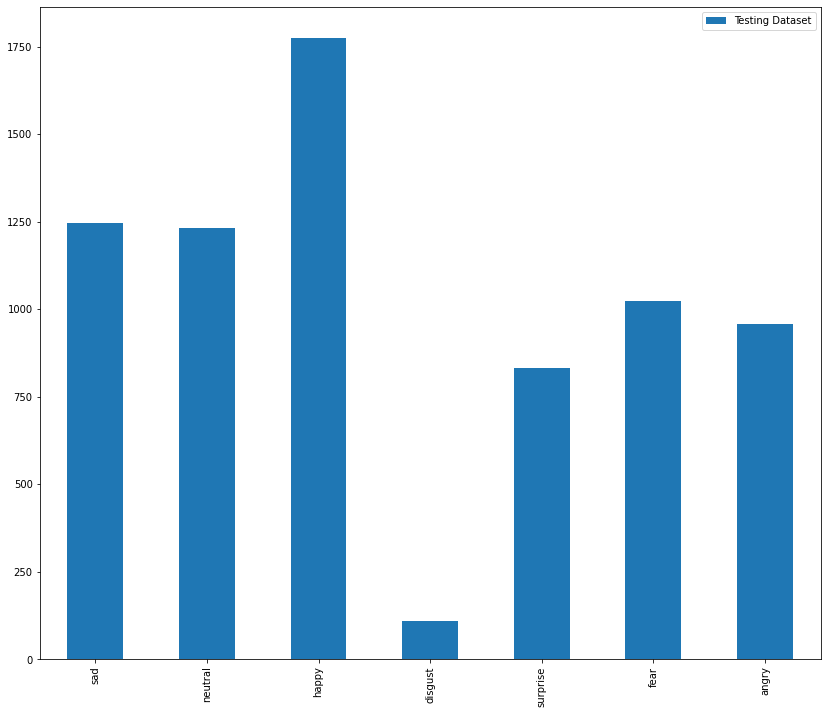

In [9]:
totalTestingImages.transpose().plot(kind='bar',figsize=(14, 12))

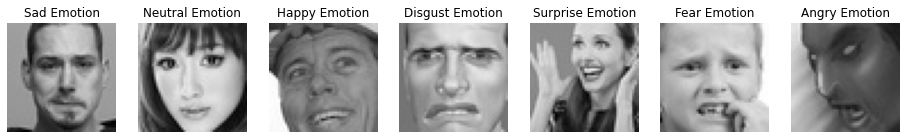

In [10]:
pyplot.figure(figsize=(16,24))
index = 1
for dir in os.listdir(training_data_directory):
    first_image = load_img((training_data_directory + dir +'/'+ os.listdir(training_data_directory + dir)[1]))
    pyplot.subplot(1,7,index)
    pyplot.imshow(first_image)
    pyplot.title(dir.capitalize() + ' Emotion')
    pyplot.axis('off')
    index = index + 1
pyplot.show()

In [11]:
model = Sequential()
batch_size = 10
epochs = 50

In [12]:
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(img_rows, img_columns, color_channels)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2))

In [13]:

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.2))

In [14]:

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2))

In [15]:

model.add(Flatten())
model.add(Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


In [16]:

model.add(Dense(units=7, activation='softmax', kernel_initializer='he_normal'))


print(model.summary())


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        2

In [17]:

early_stop = EarlyStopping(monitor='val_loss', patience=12)
model_checkpoint = ModelCheckpoint('trained_model.h5', 'val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5,verbose=1)
csv_logger = CSVLogger('training_log.log', append=False)
callbacks = [model_checkpoint, early_stop, reduce_lr, csv_logger]

In [18]:
#model summary
model_history = model.fit(
    x = training_generator,
    validation_data= validation_generator,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/50
1436/1436 [==============================] - 33s 17ms/step - loss: 2.0775 - accuracy: 0.2335 - val_loss: 1.7609 - val_accuracy: 0.3310

Epoch 00001: val_loss improved from inf to 1.76088, saving model to trained_model.h5
Epoch 2/50
1436/1436 [==============================] - 24s 17ms/step - loss: 1.6356 - accuracy: 0.3585 - val_loss: 1.5369 - val_accuracy: 0.4142

Epoch 00002: val_loss improved from 1.76088 to 1.53692, saving model to trained_model.h5
Epoch 3/50
1436/1436 [==============================] - 24s 17ms/step - loss: 1.4147 - accuracy: 0.4560 - val_loss: 1.3532 - val_accuracy: 0.4806

Epoch 00003: val_loss improved from 1.53692 to 1.35316, saving model to trained_model.h5
Epoch 4/50
1436/1436 [==============================] - 24s 17ms/step - loss: 1.3207 - accuracy: 0.4965 - val_loss: 1.3281 - val_accuracy: 0.4832

Epoch 00004: val_loss improved from 1.35316 to 1.32808, saving model to trained_model.h5
Epoch 5/50
1436/1436 [==============================] - 24s 

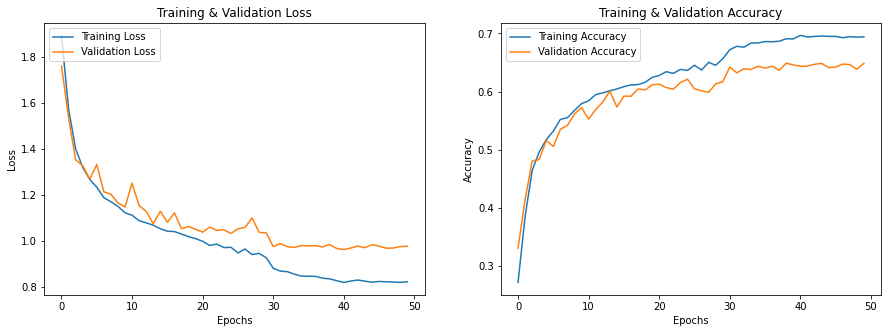

In [19]:

fig = pyplot.figure(figsize=(15,5))
ax = pyplot.subplot(1,2,2)


pyplot.plot(model_history.history['accuracy'])
pyplot.plot(model_history.history['val_accuracy'])


pyplot.title('Training & Validation Accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
pyplot.subplot(1,2,1)


pyplot.plot(model_history.history['loss'])
pyplot.plot(model_history.history['val_loss'])


pyplot.title('Training & Validation Loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend(['Training Loss', 'Validation Loss'], loc='upper left')

pyplot.show()

Confusion Matrix for the prediction:
[[134  10 130 222 203 164  95]
 [ 16   0  10  35  26  13  11]
 [140  14 141 232 223 163 111]
 [267  21 199 389 404 282 212]
 [152  10 154 321 260 169 167]
 [172   8 131 309 288 200 139]
 [102  10  83 208 187 134 107]]


([<matplotlib.axis.YTick at 0x7f699805bd30>,
 [Text(0, 0, 'angry'),
  Text(0, 0, 'disgust'),
  Text(0, 0, 'fear'),
  Text(0, 0, 'happy'),
  Text(0, 0, 'neutral'),
  Text(0, 0, 'sad'),
  Text(0, 0, 'surprise')])

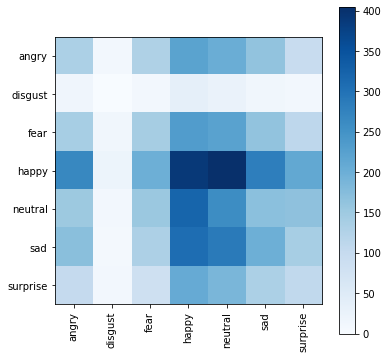

In [20]:
predictions = model.predict(x = testing_generator)

confusion_matrix_testing = confusion_matrix(y_true=testing_generator.classes, y_pred=numpy.argmax(predictions, axis=1))

print('Confusion Matrix for the prediction:')
print(confusion_matrix_testing)

pyplot.figure(figsize = (6,6))
pyplot.imshow(confusion_matrix_testing, interpolation='nearest', cmap=pyplot.cm.Blues)
pyplot.colorbar()
plot_tick_mark = numpy.arange(len(testing_generator.class_indices))
pyplot.xticks(plot_tick_mark, testing_generator.class_indices, rotation=90)
pyplot.yticks(plot_tick_mark, testing_generator.class_indices)